# Our Amazing Benchmark Evaluation

### Set path to log directory here.

In [1]:
LOG_DIR = "/Users/law/drive/msc/m3/adb/bm_results"

##  Run all cells and all the plots will magically appear :)

### Functions

In [2]:
import re

class BMRunInfo:
    def __init__(self, bm_type, bm_infos, final_info):
        self.bm_type = bm_type
        self.bm_infos = bm_infos
        self.final_info = final_info

# Example line (no linebreaks)
# 2018-08-12 18:56:45:761 10 sec: 4262 operations; 426.2 current ops/sec; est completion in 1 hour 18 minutes 
# [INSERT: Count=4266, Max=951807, Min=2522, Avg=12826.31, 90=16719, 99=58399, 99.9=947199, 99.99=951807]

BM_INFO_RE = re.compile(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}:\d{3} (\d{2,}) sec: (\d+) operations; (\d*.\d*) current ops/sec; .* \[[A-Z]+: Count=(\d*), Max=(\d*), Min=(\d*), Avg=(\d*.\d*|\d*), 90=(\d*), 99=(\d*), 99\.9=(\d*), 99\.99=(\d*)\]')

class BMInfo:
    def __init__(self, log_line):
        match = BM_INFO_RE.match(log_line)
        if match is None:
            raise ValueError("Bad log line: " + log_line)
        self.seconds = match.group(1)
        self.total_ops = match.group(2)
        self.ops_per_sec = match.group(3)
        self.ops_per_interval = match.group(4)
        self.max_latency = match.group(5)
        self.min_latency = match.group(6)
        self.avg_latecny = match.group(7)
        self.p90 = match.group(8)
        self.p99 = match.group(9)
        self.p999 = match.group(10)
        self.p9999 = match.group(11)

In [3]:
def get_bm_run_from_file(file_name):
    bm_infos = []
    final_info = {}
    bm_type = ""
    for line in open(file_name):
        if line.startswith("2018-") and "0 sec: 0 operations;" not in line:
            bm_infos.append(BMInfo(line))
            
        # [INSERT], AverageLatency(us), 1851.142024
        # [OVERALL], Throughput(ops/sec), 8293.62759124027
        # [READ], AverageLatency(us), 1948.265838
        elif line.startswith("[INSERT],") or line.startswith("[OVERALL],") or line.startswith("[READ],"):
            split_line = line.split(', ')
            final_info[split_line[1]] = int(float(split_line[2].strip()))

        if line.startswith('[INSERT]'):
            bm_type = "INSERT"
        elif line.startswith('[READ]'):
            bm_type = "READ"
            
    assert(bm_type != "")
    return BMRunInfo(bm_type, bm_infos, final_info)        

In [6]:
import os
from collections import defaultdict

RUN_FILE_RE = re.compile(r"^(run_\d{1,2}-)")

def get_bm_runs(log_dir):
    runs = defaultdict(list)
    for dir_path, dirs, files in os.walk(log_dir):
        for file in files:
            if not file.endswith(".txt") or file.endswith("FAILED.txt"):
                continue
            
            run_prefix = RUN_FILE_RE.match(file)
            if run_prefix is not None:
                file_key = file[len(run_prefix.group(1)):]            
            else:
                file_key = file
            
            runs[file_key].append(get_bm_run_from_file(os.path.join(dir_path, file)))
    return runs
    

In [11]:
from collections import defaultdict

def get_final_info(runs, file_type):
    res = defaultdict(list)
    for file, runs in runs.items():
        if file.startswith(file_type):
            for run in runs:
                res[file].append(run.final_info)
                
    return res

In [13]:
RUNS = get_bm_runs(LOG_DIR)
LOADS = get_final_info(RUNS, 'load')
READS = get_final_info(RUNS, 'read')

In [14]:
print(LOADS)

defaultdict(<class 'list'>, {'load_capacity_500000-num_stores_1.txt': [{'RunTime(ms)': 186632, 'Throughput(ops/sec)': 10716, 'Operations': 2000000, 'AverageLatency(us)': 1445, 'MinLatency(us)': 544, 'MaxLatency(us)': 5300223, '95thPercentileLatency(us)': 1903, '99thPercentileLatency(us)': 4955, 'Return=OK': 2000000}, {'RunTime(ms)': 181688, 'Throughput(ops/sec)': 11007, 'Operations': 2000000, 'AverageLatency(us)': 1405, 'MinLatency(us)': 543, 'MaxLatency(us)': 4935679, '95thPercentileLatency(us)': 1888, '99thPercentileLatency(us)': 4295, 'Return=OK': 2000000}, {'RunTime(ms)': 186959, 'Throughput(ops/sec)': 10697, 'Operations': 2000000, 'AverageLatency(us)': 1445, 'MinLatency(us)': 537, 'MaxLatency(us)': 5246975, '95thPercentileLatency(us)': 1761, '99thPercentileLatency(us)': 4031, 'Return=OK': 2000000}, {'RunTime(ms)': 187061, 'Throughput(ops/sec)': 10691, 'Operations': 2000000, 'AverageLatency(us)': 1448, 'MinLatency(us)': 535, 'MaxLatency(us)': 5824511, '95thPercentileLatency(us)': 1

In [18]:
def capacity_from_file(file):
    # read_capacity_1000-num_stores_1.txt
    match = re.search(r'capacity_(\d*)', file)
    if match is None:
        raise ValueError("bad file name: " + file)
    
    return int(match.group(1))

## Plots

In [68]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'pgf.rcfonts' : False})

In [117]:
def print_metric_single_line(runs, metric, capacity, name):
    print('%8d' % capacity, sorted(list(run[metric] for run in runs[f"{name}_capacity_{capacity}-num_stores_1.txt"])))

def print_metric_single(runs, metric, name):
    capacities = [1000, 10000, 50000, 100000, 500000, 1000000, 10000000]
    print("\n")
    print(name, metric)
    for cap in capacities:
        print_metric_single_line(runs, metric, cap, name)

def print_metrics(metrics):
    for metric in metrics:
        print_metric_single(LOADS, metric, "load")
        print_metric_single(READS, metric, "read")

In [110]:
import matplotlib.pyplot as plt
from collections import defaultdict

def get_info_per_capacity(runs, info_name):
    cap_final_infos = []
    for file, infos in runs.items():
        cap = capacity_from_file(file)
        info_list = []
        for info in infos:    
            info_list.append(info[info_name])
        cap_final_infos.append((cap, info_list))
        
#     file_infos = [(file, info[info_name]) for file, info in runs.items()]
#     cap_final_infos = [(capacity_from_file(f), info) for f, info in file_infos]
    cap_final_infos.sort(key=lambda x: x[0])
    caps, infos = list(zip(*cap_final_infos))
    return caps, infos

def plot_info_per_capacity(info_name, out_file_name, save_fig = False):
    print(info_name, "\n" + ("=") * len(info_name) )
    load_caps, load_infos = get_info_per_capacity(LOADS, info_name)
    read_caps, read_infos = get_info_per_capacity(READS, info_name)

    caps = list(range(len(load_caps)))
    
#     plt.boxplot(caps, load_infos, 'r--o', caps, read_infos, 'b--^')
#     plt.ylabel(info_name)
#     plt.xlabel("Partition capacity")
#     plt.ylim(ymin=0)
    
#     max_y = int(max(max(load_infos), max(read_infos)) * 1.1)
#     plt.axis([0, 7, 0, max_y])
#     plt.xticks(range(len(caps)), [str(x) for x in load_caps], rotation="vertical")
    
#     plt.legend(["INSERT", "READ"])

#     plt.savefig(f"{out_file_name}.svg")
#     plt.show()

############ LOAD ############ 
    plt.boxplot(load_infos, labels=[str(x) for x in load_caps], showfliers=False, whis="range")
    plt.ylabel(info_name)
    plt.xlabel("Partition capacity")
    plt.ylim(ymin=0)
    plt.xticks(rotation=90)
    plt.legend(["INSERT"])

    if save_fig:
        plt.savefig(f"load_{out_file_name}.svg")
        plt.savefig(f"load_{out_file_name}.pgf")
    plt.show()
    
############ READ ############     
    plt.boxplot(read_infos, labels=[str(x) for x in read_caps], showfliers=False, whis="range")
    plt.ylabel(info_name)
    plt.xlabel("Partition capacity")
    plt.ylim(ymin=0)
    plt.xticks(rotation=90)
    plt.legend(["READ"])

    if save_fig:
        plt.savefig(f"read_{out_file_name}.svg")
        plt.savefig(f"read_{out_file_name}.pgf")
    plt.show()
    


Throughput(ops/sec) 


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


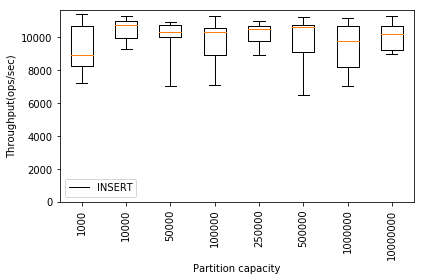

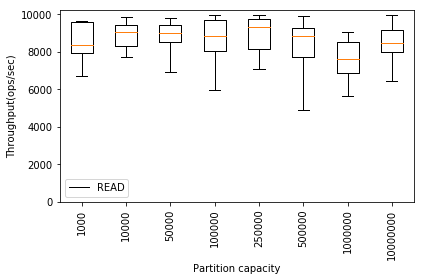

AverageLatency(us) 


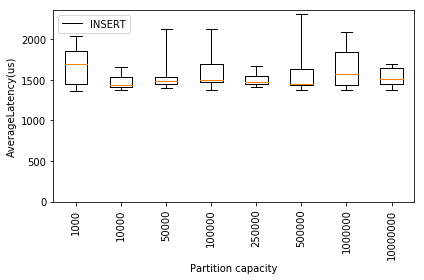

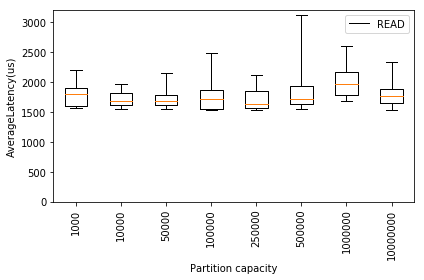

99thPercentileLatency(us) 


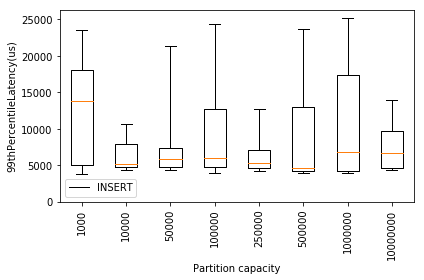

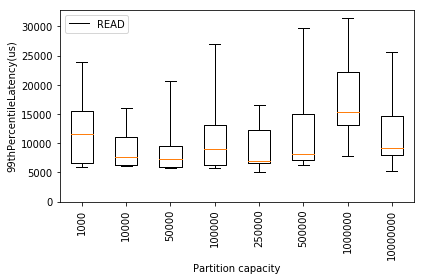

In [111]:
info_names = [
    ('Throughput(ops/sec)', 'throughput'),
#     ('RunTime(ms)', 'runtime'),
    ('AverageLatency(us)', 'avg_latency'),
#     ('MinLatency(us)', 'min_latency'),
#     ('MaxLatency(us)', 'max_latency'),
#     ('95thPercentileLatency(us)', '95p_latency'),
    ('99thPercentileLatency(us)', '99p_latency')
]

for info_name, out_file_name in info_names:
    plot_info_per_capacity(info_name, out_file_name)


In [118]:
METRICS = [
    'Throughput(ops/sec)',
    'AverageLatency(us)',
    '99thPercentileLatency(us)'
]

print_metrics(METRICS)



load Throughput(ops/sec)
    1000 [7255, 7637, 8127, 8293, 8472, 8670, 9247, 10292, 10704, 10708, 10860, 11431]
   10000 [9267, 9608, 9750, 10011, 10644, 10732, 10777, 10816, 10955, 11059, 11156, 11321]
   50000 [7072, 8675, 9906, 10055, 10196, 10257, 10371, 10564, 10723, 10841, 10946, 10949]
  100000 [7090, 8194, 8868, 8922, 9534, 10261, 10386, 10392, 10476, 10857, 10862, 11315]
  500000 [6488, 8506, 8756, 9240, 9975, 10618, 10691, 10697, 10716, 10870, 11007, 11247]
 1000000 [7073, 7519, 8211, 8219, 8289, 9377, 10211, 10222, 10680, 10809, 11132, 11193]
10000000 [8993, 9063, 9102, 9268, 10156, 10202, 10203, 10237, 10644, 10901, 10901, 11312]


read Throughput(ops/sec)
    1000 [6704, 7684, 7757, 7968, 8014, 8026, 8675, 9343, 9536, 9628, 9640, 9654]
   10000 [7727, 7861, 8235, 8296, 8670, 8976, 9059, 9276, 9366, 9562, 9590, 9861]
   50000 [6903, 7835, 8159, 8630, 8776, 8977, 9053, 9278, 9320, 9632, 9712, 9794]
  100000 [5932, 6412, 7459, 8206, 8611, 8637, 9000, 9369, 9637, 9858, 9941,

In [119]:
import numpy as np

data = [1545, 1579, 1597, 1621, 1636, 1668, 1700, 1764, 1807, 1834, 1907, 1957]
dev = np.std(data)
mean = np.mean(data)

print(dev)
print(dev / mean)

128.83546246623595
0.07499517582317881
